In [1]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [50]:
from tqdm.auto import tqdm
from itertools import islice
from datetime import datetime
from collections import Counter
import textwrap

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (accuracy_score, 
                             confusion_matrix, classification_report,
                             ConfusionMatrixDisplay)
output_paths = []

## Data dependencies

```
../data/verb_morpho.csv 4ecd72
../data/verb_morpho_emb.txt a9a9b8
```

In [4]:
from hashlib import sha1
from pathlib import Path
paths = ["../data/verb_morpho.csv", "../data/verb_morpho_emb.txt"]
for path_x in paths:
    h = sha1()
    h.update(Path(path_x).read_bytes())
    print(path_x, h.hexdigest()[:6])

../data/verb_morpho.csv 4ecd72
../data/verb_morpho_emb.txt a9a9b8


## Load dependencies

In [5]:
mr_data = pd.read_csv("../data/verb_morpho.csv")
kv = KeyedVectors.load_word2vec_format("../data/verb_morpho_emb.txt")

## Make dataset

In [10]:
mr_data.iloc[:1, ]

,Unnamed: 0,token,source,ASBC,Apple (2006-2016),China (2015-2016),Dcard (2019-2020),PTT (2004-2019),MorphoSyntax
0,4073,丟來,Corpus,1.0,5.0,5.0,1.0,0.0,VR


In [28]:
Xall, yall = [], []
dropped = []
for row in mr_data.itertuples():
    c1, c2 = list(row.token)
    if c1 in kv and c2 in kv:
        c1_vec = kv.get_vector(c1, norm=True)
        c2_vec = kv.get_vector(c2, norm=True)
        Xall.append(np.concatenate([c1_vec, c2_vec]))
        yall.append(row.MorphoSyntax)
    else:
        dropped.append((row.token, row.MorphoSyntax))
Xall = np.array(Xall)
yall = np.array(yall)

In [29]:
## Dropped items due to no single-character word vectors
print(*textwrap.wrap(" ".join(str(x) for x in dropped)), sep="\n")

('摩醞', 'AV') ('攙入', 'VR') ('攙有', 'VR') ('決隄', 'VO') ('發訃', 'VO')
('輾去', 'VR') ('輾死', 'VR') ('輾碎', 'VR') ('顛躓', 'VV') ('餓癟', 'VR')


In [33]:
print("All instances: ", Xall.shape[0])
print("label distribution")
print(Counter(yall).most_common())
assert Xall.shape[0] == yall.shape[0]

All instances:  1666
label distribution
[('VR', 873), ('AV', 339), ('VV', 243), ('VO', 211)]


## Splitting

In [70]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xall, yall, test_size=0.2, random_state=1234)

In [71]:
lda = LinearDiscriminantAnalysis()
lda.fit(Xtrain, ytrain)
ypred = lda.predict(Xtest)

print("Accuracy: {:.4f}".format(accuracy_score(ytest, ypred)))
print(classification_report(ytest, ypred))

Accuracy: 0.7156
              precision    recall  f1-score   support

          AV       0.62      0.55      0.58        67
          VO       0.61      0.62      0.62        48
          VR       0.85      0.88      0.87       172
          VV       0.43      0.43      0.43        47

    accuracy                           0.72       334
   macro avg       0.63      0.62      0.62       334
weighted avg       0.71      0.72      0.71       334



(array([0, 1, 2, 3]),
 [Text(0, 0, 'AV'), Text(0, 1, 'VO'), Text(0, 2, 'VR'), Text(0, 3, 'VV')])

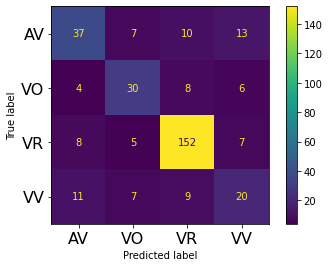

In [72]:
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(ytest, ypred)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)